## Declarations

### Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend
print(tf.__version__)

2.11.0


### Constants

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
image_dir = "./resized_train"
#image_dir = "./colors"
caption_pred_file = "caption_prediction_train.csv"
#caption_pred_file = "caption_prediction.csv"
concept_det_file = "concept_detection_train.csv"
concept_file = "concepts.csv"

In [ ]:
batch_size = 64
epochs = 100

## Preprocessing

### File reading

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Hackaton
#!unzip resized_train.zip

Mounted at /gdrive
/gdrive/My Drive/Hackaton


In [ ]:
concepts = pd.read_csv(concept_file, sep='\t')
concept_list = concepts.set_index('concept')['concept_name'].to_dict()

captions = pd.read_csv(caption_pred_file, sep='\t')
captions = captions.set_index('ID')['caption'].to_dict()
captions = {id: "[SOS] " + caption + " [EOS]" for id, caption in captions.items()}

concepts = pd.read_csv(concept_det_file, sep='\t')
concepts = concepts.set_index('ID')['cuis'].to_dict()
concepts = {id: item_concepts.split(";") for id, item_concepts in concepts.items()}

In [ ]:
# Define a list of characters to strip from input text
strip_chars = string.punctuation

# Remove "[" and "]" from the list of stripped characters
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    # convert input string to lowercase
    lowercase = tf.strings.lower(input_string)
    # replace special characters with empty string
    # TODO
    #return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")
    return lowercase

In [ ]:
text_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=custom_standardization,
)

train_captions = [v for v in captions.values()]
text_vectorization.adapt(train_captions)

In [ ]:
result = ""
for i in captions.values():
    result += " " + i
result = custom_standardization(result)
result = bytes.decode(result.numpy())
vocab_size = len(set(result.split()))
print("Vocab size:")
print(vocab_size)

longest = max(captions.values(), key=len)
longest = custom_standardization(longest)
longest = bytes.decode(longest.numpy())
longest = longest.split()
sequence_length = len(longest)
print("Longest sequence:")
print(sequence_length)

concept_size = max([len(arr) for arr in concepts])
print("Max number of concepts:")
print(concept_size)

Vocab size:
35491
Longest sequence:
393
Max number of concepts:
37


### Generating dataset

In [ ]:
def load_data(image_dir, image_captions, image_concepts = None, limit=0):
    images = []
    captions = []
    concepts = [] if image_concepts else None
    raw_captions = []
    image_paths = []

    n = 0
    
    files = [filename for filename in os.listdir(image_dir)]
    if limit != 0:
        files = random.sample(files, limit)
        
    for filename in files:
        name = os.path.splitext(filename)[0]
        if name not in image_captions:
            continue

        image_path = os.path.join(image_dir, name + ".jpg")
        image = cv2.imread(image_path)

        # Preprocess images
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 
        
        # Preprocess texts
        text = image_captions[name]
        text = text_vectorization(image_captions[name])

        # Preprocess concepts
        if image_concepts:
          classes = image_concepts[name]
          classes = np.pad(classes, (0, concept_size - len(classes)), constant_values = None)
          concepts.append(classes)
        
        images.append(image)
        captions.append(text)
        raw_captions.append(image_captions[name])
        image_paths.append(image_path)

        n = n + 1
            
    return n, (images, captions, raw_captions, concepts, image_paths)

def load_dataset(image_dir, image_captions, image_concepts = None, limit=0, test=0.2, val=0.0):
    n_items, data_pairs = load_data(image_dir, image_captions, image_concepts, limit)
    ds = tf.data.Dataset.from_tensor_slices(data_pairs)
    ds = ds.map(lambda i, c, rc, cc, ip: {'image': i, 'caption': c, 'raw caption': rc, 'concepts': cc, 'image path': ip})

    test_size = np.round(n_items * test)
    val_size = np.round(n_items * val)
    
    ds = ds.shuffle(n_items)
    val_dataset = ds.take(val_size)
    train_dataset = ds.skip(val_size)
    test_dataset = train_dataset.take(test_size)
    train_dataset = train_dataset.skip(test_size)
    
    return train_dataset, val_dataset, test_dataset

def base_dataset(dataset):
    return dataset.map(lambda x: {'image': x['image'], 'caption': x['caption']})

def visualize_dataset(dataset, nums=5):
    for n, (i, t) in enumerate(random.sample(dataset, nums)):
        plt.figure(figsize=(50, 100))
        plt.subplot(nums, 1, n + 1)
        plt.imshow(i)
        plt.title(f"{t}", fontsize=100)
        plt.xticks([])
        plt.yticks([])
      

In [ ]:
ds_train, ds_val, ds_test = load_dataset(image_dir, captions, concepts, limit=10, test=0, val=0.2)

In [ ]:
# visualize_dataset(ds_train, 5)

## Network

### Network blocks

In [ ]:
def CNN_embedding(input_shape, latent_dim, embed_dim, seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='img_input_layer')
    x = tfkl.ZeroPadding2D((2,2))(input_layer)

    x = tfkl.Conv2D(64, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Flatten()(x)
    x = tfkl.Dense(latent_dim, activation='relu')(x)
    x = tfkl.Dense(embed_dim, name='img_embedding_output_layer')(x)

    # Connect input and output through the Model class
    cnn_encoder = tfk.Model(inputs=input_layer, outputs=x, name='image_encoder')

    # Return the discriminator
    return cnn_encoder

In [ ]:
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Embedding layer for the token
        self.token_emb = tfkl.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Embedding layer for the position
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Find the maximum length of the input
        maxlen = tf.shape(x)[-1]
        # Create a tensor with positions from 0 to maxlen-1
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Embed the positions
        positions = self.pos_emb(positions)
        # Embed the tokens
        x = self.token_emb(x)
        # Add the token and position embeddings
        return x + positions

In [ ]:
class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential(
            [
                tfkl.Dense(ff_dim, activation="relu"), 
                tfkl.Dense(embed_dim)
            ]
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)
        
    def call(self, inputs, training):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add the attention output to the input and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add the feed-forward output to the previous output and normalize
        return self.layernorm2(out1 + ffn_output)

In [ ]:
def text_embedding(sequence_lenght, vocab_size, num_heads, embed_dim, latent_dim):
    input_layer = tfk.Input(shape=(None,), dtype="int64", name="text_inputs")
    x = TokenAndPositionEmbedding(sequence_lenght, vocab_size, embed_dim)(input_layer)
    x = TransformerEncoderBlock(embed_dim, num_heads, latent_dim)(x)
    
    text_encoder = tfk.Model(input_layer, x)
    
    return text_encoder

In [ ]:
class CLIP(tfk.Model):
    def __init__(self, image_encoder, text_encoder, temp=0.07, **kwargs):
        super().__init__(**kwargs)
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.temp = temp
        self.loss_tracker = tfk.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        image_emb = self.image_encoder(features["image"], training=training)
        text_emb = self.text_encoder(features["caption"], training=training)
        return image_emb, text_emb

    def CLIP_loss(self, image_emb, text_emb):
        norm_image_emb = tf.math.l2_normalize(image_emb, axis=1)
        norm_text_emb = tf.math.l2_normalize(text_emb, axis=1)

        logits = tf.linalg.matmul(norm_image_emb, norm_text_emb, transpose_b=True) * tf.math.exp(self.temp)

        n = tf.shape(logits)[0]
        labels = tf.range(n)

        loss_img = tfk.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_txt = tfk.losses.sparse_categorical_crossentropy(labels, kb.transpose(logits), from_logits=True)

        return (loss_img + loss_txt)/2

        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        #images_similarity = tf.matmul(
        #    image_embeddings, image_embeddings, transpose_b=True
        #)
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        #captions_similarity = tf.matmul(
        #    caption_embeddings, caption_embeddings, transpose_b=True
        #)
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        #targets = keras.activations.softmax(
        #    (captions_similarity + images_similarity) / (2 * self.temperature)
        #)
        # Compute the loss for the images using crossentropy
        #images_loss = keras.losses.categorical_crossentropy(
        #    y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        #)
        # Compute the loss for the captions using crossentropy
        #captions_loss = keras.losses.categorical_crossentropy(
        #    y_true=targets, y_pred=logits, from_logits=True
        #)
        # Return the mean of the loss over the batch.
        #return (captions_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            image_embeddings, caption_embeddings = self(features, training=True)
            loss = self.CLIP_loss(caption_embeddings, image_embeddings)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        image_embeddings, caption_embeddings = self(features, training=False)
        loss = self.CLIP_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


### Building network

In [ ]:
def build_clip(img_input_shape=(128, 128, 3),
               txt_input_shape=(393, ), 
               latent_dim=1024, 
               embed_dim=128, 
               seq_lenght=393, 
               vocab_size=35491, 
               num_heads=4,
               temp=0.07):
    
    img_input = tfk.Input(shape=img_input_shape)
    txt_input = tfk.Input(shape=txt_input_shape)
    
    img_embed = CNN_embedding(img_input_shape, latent_dim, embed_dim, seed=42)(img_input)
    image_encoder = tfk.Model(img_input, img_embed, name = "image_encoder")

    txt_embed = text_embedding(seq_lenght, vocab_size, num_heads, embed_dim, latent_dim)(txt_input)
    txt_embed = tfkl.GlobalAveragePooling1D()(txt_embed)
    txt_embed = tfkl.Dense(embed_dim, name="text_encoder")(txt_embed)
    text_encoder = tfk.Model(txt_input, txt_embed, name = "text_encoder")

    clip = CLIP(image_encoder, text_encoder, temp)
    clip.compile(optimizer = tf.optimizers.Adam())
    return image_encoder, text_encoder, clip

In [ ]:
image_encoder, text_encoder, clip = build_clip()
# model.summary()

## Training

### CLIP pre-training

In [ ]:
# Create a learning rate scheduler callback.
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor = "val_loss", factor = 0.2, patience = 3
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 5, restore_best_weights = True
)

base_ds_train = base_dataset(ds_train)
base_ds_val = base_dataset(ds_val)

history = clip.fit(
    base_ds_train.batch(10),
    epochs = epochs,
    validation_data = base_ds_val.batch(10),
    callbacks = [reduce_lr, early_stopping],
)

Epoch 1/100
737/737 [==============================] - 68s 72ms/step - loss: 2.3021 - val_loss: 2.3026 - lr: 0.0010
Epoch 2/100
737/737 [==============================] - 34s 46ms/step - loss: 2.1840 - val_loss: 2.0385 - lr: 0.0010
Epoch 3/100
737/737 [==============================] - 33s 44ms/step - loss: 2.0303 - val_loss: 1.9987 - lr: 0.0010
Epoch 4/100
737/737 [==============================] - 33s 45ms/step - loss: 1.9632 - val_loss: 1.9181 - lr: 0.0010
Epoch 5/100
737/737 [==============================] - 33s 44ms/step - loss: 1.8957 - val_loss: 1.8420 - lr: 0.0010
Epoch 6/100
737/737 [==============================] - 32s 43ms/step - loss: 1.8551 - val_loss: 1.8321 - lr: 0.0010
Epoch 7/100
737/737 [==============================] - 32s 44ms/step - loss: 1.8116 - val_loss: 1.7799 - lr: 0.0010
Epoch 8/100
737/737 [==============================] - 32s 43ms/step - loss: 1.7877 - val_loss: 1.7569 - lr: 0.0010
Epoch 9/100
737/737 [==============================] - 32s 43ms/step - l

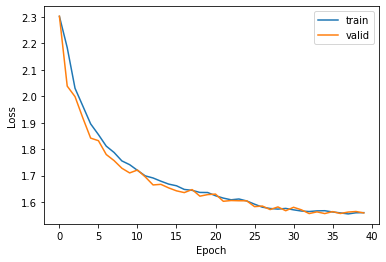

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
clip.save("keras_clip_model")

### Encoder/Decoder training

In [ ]:
def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return image_array

In [ ]:
def find_matches(image_embeddings, queries, k=5, normalize=True):
    queries_vec = [text_vectorization(query) for query in queries]
    queries_vec = tf.data.Dataset.from_tensor_slices(queries_vec).batch(batch_size)
    # Get the embedding for the query.
    query_embedding = text_encoder.predict(queries_vec)
    # Normalize the query and the image embeddings.
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings.
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices.
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    # Return matching image paths.
    return [[train_image_paths[idx] for idx in indices] for indices in results]

In [ ]:
train_data = [p for p in ds_train]
val_data = [p for p in ds_val]
test_data = [p for p in ds_test]

train_image_paths = [e["image path"] for e in train_data]
test_image_paths = [e["image path"] for e in test_data]

# TODO: this part only generates embeddings on the training dataset for now
# TODO: this code re-reads the images
image_embeddings = image_encoder.predict(
    tf.data.Dataset.from_tensor_slices(train_image_paths).map(read_image).batch(batch_size),
    verbose=1,
)
print(f"Image embeddings shape: {image_embeddings.shape}.")


Generating embeddings for 7362 images...
116/116 [==============================] - 6s 52ms/step
Image embeddings shape: (7362, 128).


1/1 [==============================] - 0s 14ms/step
Top matches for query: "active pheochromocytoma"
tf.Tensor(b'[SOS] the distal chevron osteotomy and kirschner kwire fixationblack arrow show the kirschnerwire fixation of the distal metatarsal chevron osteotomy [EOS]', shape=(), dtype=string)
tf.Tensor(b'[SOS] a panoramic image show conical crown with dilated root in relation to  and  pathologic migration of  and  elevation of left nasal floor [EOS]', shape=(), dtype=string)
tf.Tensor(b'[SOS] initial xray of the dislocate proximal humeral fracture scapulayview [EOS]', shape=(), dtype=string)
tf.Tensor(b'[SOS] leave ventriculography show mid ventricular obstruction during systolic phase [EOS]', shape=(), dtype=string)
tf.Tensor(b'[SOS] the orthopantamograph reveal multiple impact tooth in the mandilble red arrow with multiloculate osteolytic lesion involve mandible and maxilla blue arrow [EOS]', shape=(), dtype=string)
tf.Tensor(b'[SOS] post sequestrectomy anteroposterior view [EOS]', 

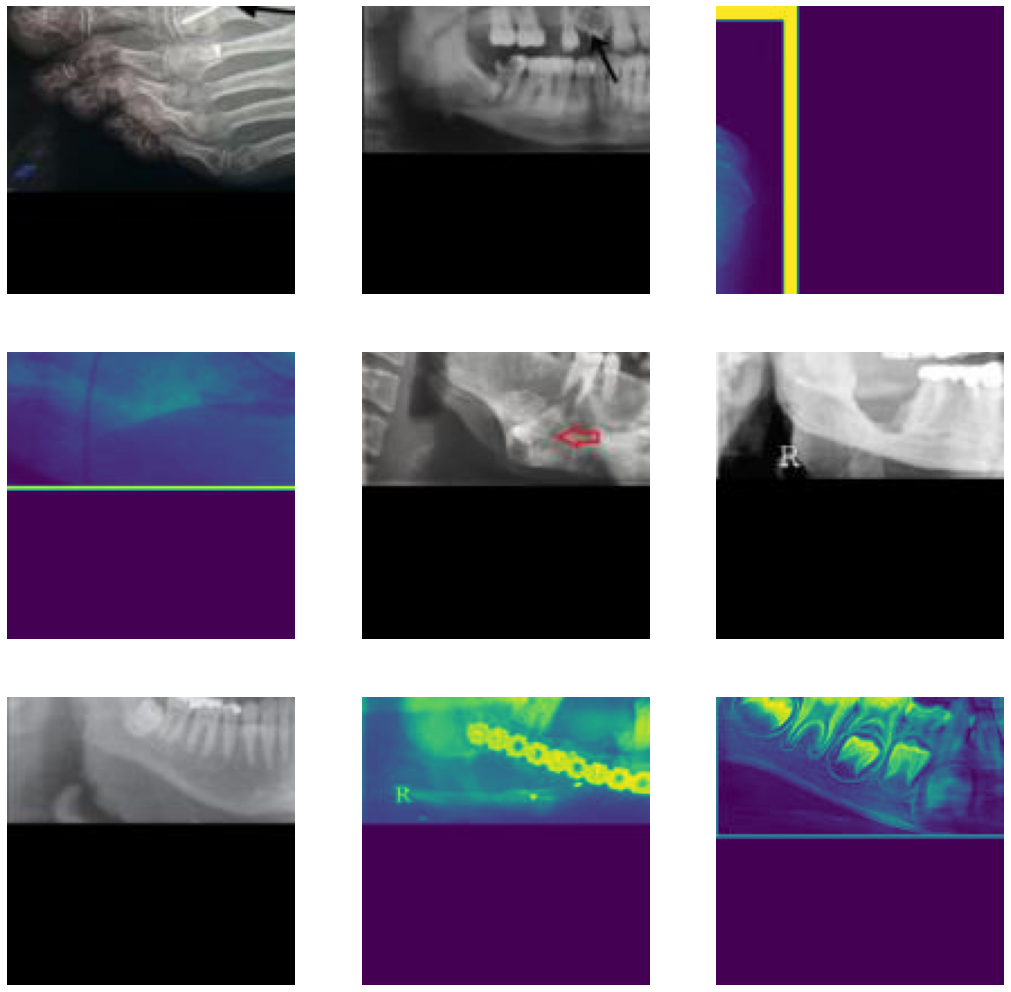

In [ ]:
query = "active pheochromocytoma"
matches = find_matches(image_embeddings, [query], normalize=True)[0]

print("Top matches for query: \"" + query + "\"")

plt.figure(figsize=(18, 18))
for i in range(9):
    path = matches[i].numpy().decode('UTF-8')
    caption = next(x["raw caption"] for x in train_data if x["image path"].numpy().decode('UTF-8') == path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(path))
    plt.axis("off")
    print(caption)


## Evaluation

In [ ]:
# TODO: might not work, needs revising

def compute_top_k_accuracy(image_paths, k=5):
    hits = 0
    num_batches = int(np.ceil(len(image_paths) / batch_size))
    for idx in range(num_batches):
        start_idx = idx * batch_size
        end_idx = start_idx + batch_size
        current_image_paths = image_paths[start_idx:end_idx]
        queries = [ captions[os.path.splitext(image_path.numpy().decode('UTF-8').split(os.sep)[-1])[0]] for image_path in current_image_paths ]
        result = find_matches(image_embeddings, queries, k)
        hits += sum(
            [
                image_path in matches for (image_path, matches) in list(zip(current_image_paths, result))
            ]
        )

    return hits / len(image_paths)

n = 1920

print(test_image_paths)

print("Scoring training data...")
train_accuracy = compute_top_k_accuracy(random.sample(train_image_paths, n))
print(f"Train accuracy: {round(train_accuracy * 100, 3)}%")

print("Scoring evaluation data...")
eval_accuracy = compute_top_k_accuracy(random.sample(test_image_paths, n))
print(f"Eval accuracy: {round(eval_accuracy * 100, 3)}%")


[]
Scoring training data...
1/1 [==============================] - 0s 41ms/step
Train accuracy: 0.156%
Scoring evaluation data...


ValueError: ignored